In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-11-09 15:07:16.433914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:07:16.824404: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 15:07:17.807521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-09 15:07:17.807594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
n_channels = 16
alpha = 0.1

In [27]:
def load_image(filename, threshold=0.0):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0

    # add transparency channel for black pixels

    if threshold > 0.0:
        img[img[:,:,0] < threshold] = [0, 0, 0, 0]
        img[img[:,:,0] >= threshold] = [1, 0, 0, 1]

    
    # add red border around the image
    #img[0, :, :] = [1, 0, 0, 1]
    #img[-1, :, :] = [1, 0, 0, 1]
    #img[:, 0, :] = [1, 0, 0, 1]
    #img[:, -1, :] = [1, 0, 0, 1]

    
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [28]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_live_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [29]:
model = NNA(n_channels)

In [30]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [31]:
velocity = []
dye = []
curl = []
anim_len = 300

for i in range(anim_len):
    velocity.append(load_image('../data/export/frame_vel_' + f'{i:05d}' + '.png'))
    dye.append(load_image('../data/export/frame_dye_' + f'{i:05d}' + '.png', 0.1))
    curl.append(load_image('../data/export/frame_curl_' + f'{i:05d}' + '.png'))

    

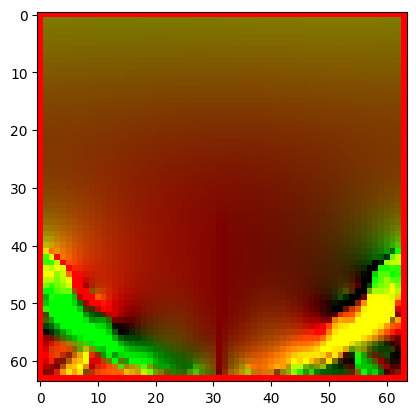

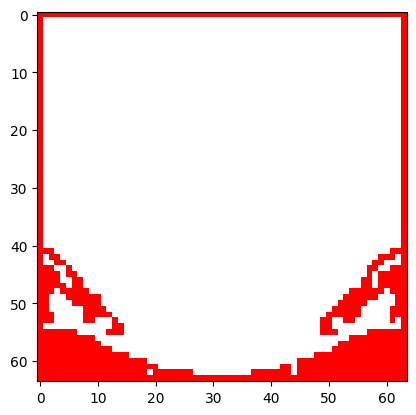

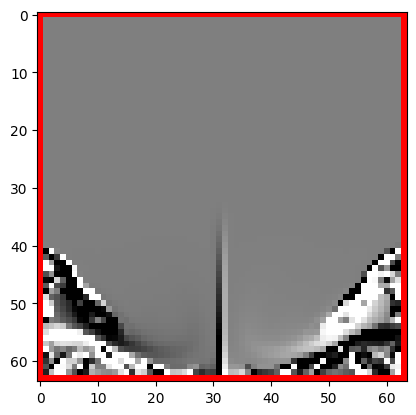

In [32]:
plot(velocity[int(anim_len*0.2)])
plot(dye[int(anim_len*0.2)])
plot(curl[int(anim_len*0.2)])

In [233]:
def init_image(step):
    return tf.identity(anim[step])

In [242]:
def loss_f(i, x):
    return loss_object(rgba(anim[i]), rgba(x))

def train(iterations):
    oracle_time = 10
    # pick a random frame from the animation
    n = np.random.randint(0,anim_len-oracle_time,size=iterations)
    j = 0
    for i in n:
        j += 1

        x = init_image(i)
        with tf.GradientTape() as g:
            for _ in range(oracle_time):
                x= model(x, 1)
            # loss is computed with the difference between the current frame and the next frame
            loss = loss_f(i+oracle_time, x) * 100
            
        gradients = g.gradient(loss, model.weights)
        gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
        optimizer.apply_gradients(zip(gradients, model.weights))

        if j % 100 == 0:
            f, axs = plt.subplots(1, 3)
            template = 'Epoch {}, Loss: {}'
            print(template.format(j + 1, loss))
            axs[0].imshow(rgb(anim[i]))
            axs[1].imshow(rgb(x))
            axs[2].imshow(rgb(anim[i + oracle_time]))
            plt.show()
                
    return x, loss

Epoch 101, Loss: 3.7383065223693848


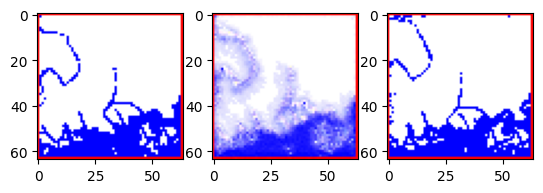

Epoch 201, Loss: 1.1945003271102905


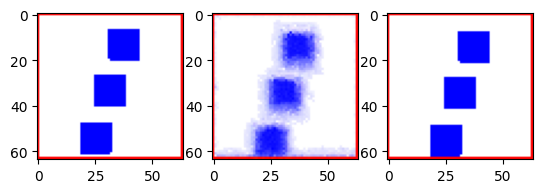

Epoch 301, Loss: 5.790740013122559


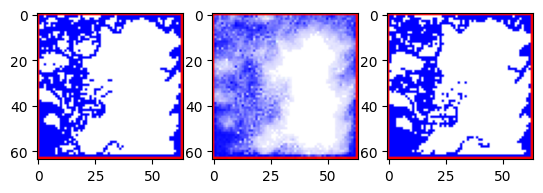

Epoch 401, Loss: 7.4250807762146


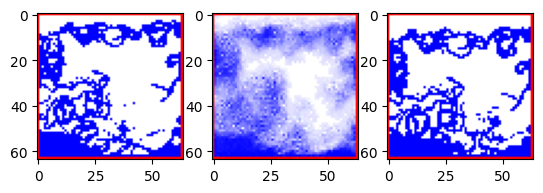

Epoch 501, Loss: 2.1846680641174316


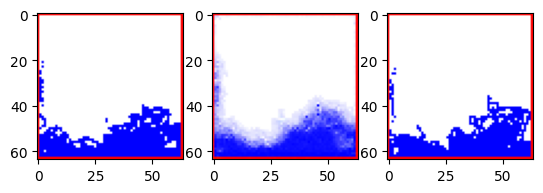

Epoch 601, Loss: 7.785850524902344


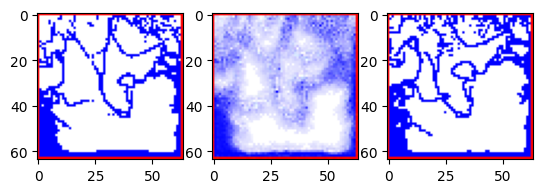

Epoch 701, Loss: 7.008132457733154


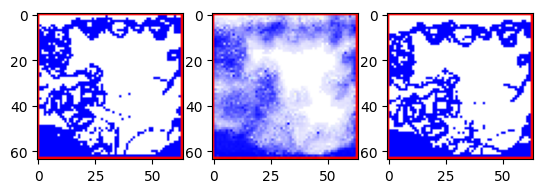

Epoch 801, Loss: 6.100833892822266


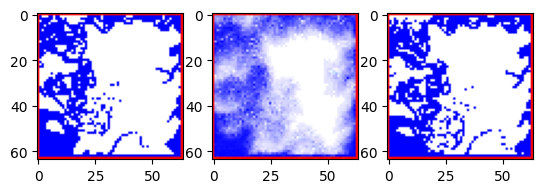

Epoch 901, Loss: 0.7611078023910522


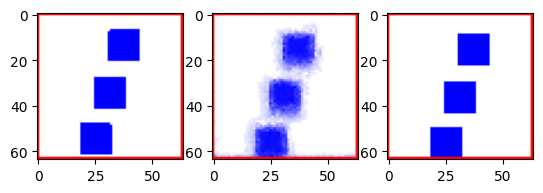

Epoch 1001, Loss: 3.0202953815460205


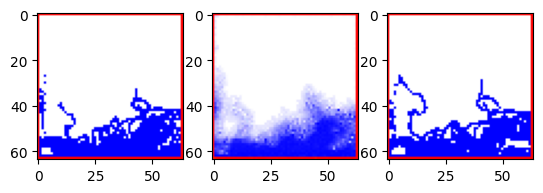

Epoch 1101, Loss: 2.886113166809082


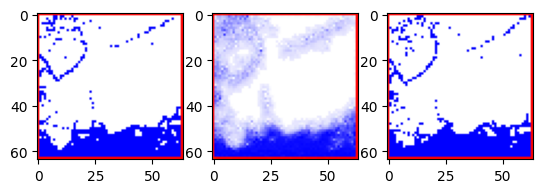

Epoch 1201, Loss: 7.743458271026611


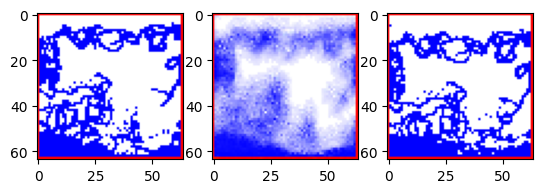

Epoch 1301, Loss: 3.1172561645507812


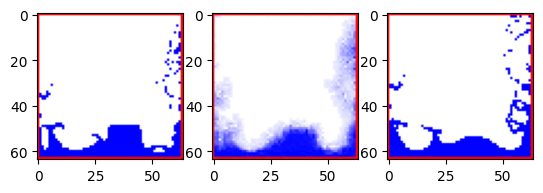

Epoch 1401, Loss: 7.487308979034424


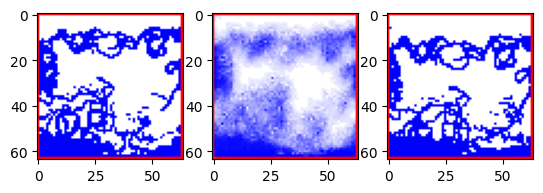

Epoch 1501, Loss: 5.395511627197266


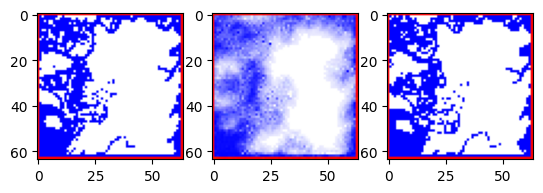

Epoch 1601, Loss: 3.1087498664855957


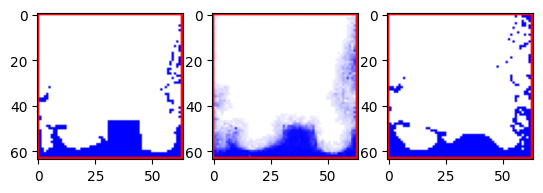

Epoch 1701, Loss: 6.108109474182129


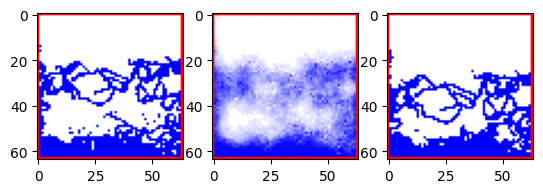

Epoch 1801, Loss: 6.281597137451172


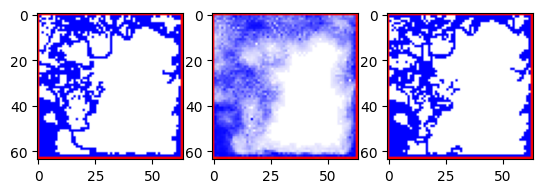

Epoch 1901, Loss: 3.5110766887664795


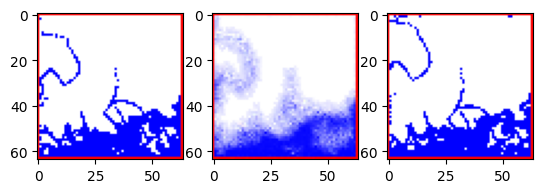

Epoch 2001, Loss: 6.183720588684082


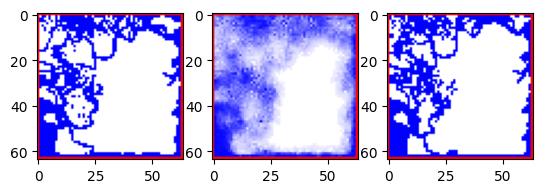

Epoch 2101, Loss: 3.24186372756958


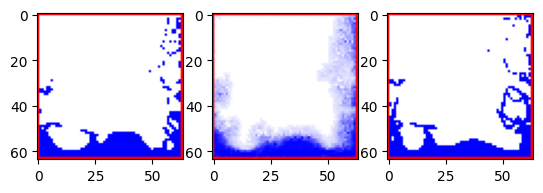

Epoch 2201, Loss: 1.2383867502212524


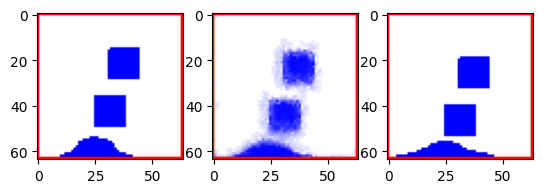

Epoch 2301, Loss: 3.182034492492676


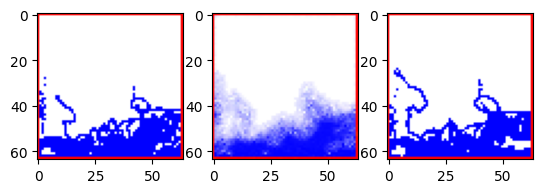

Epoch 2401, Loss: 6.004077911376953


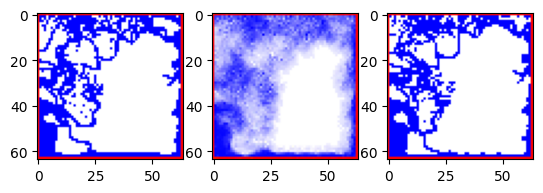

Epoch 2501, Loss: 3.2780416011810303


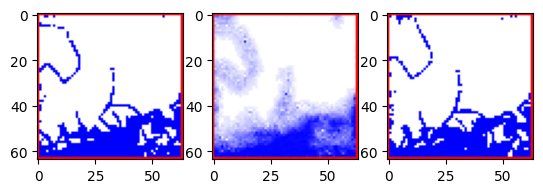

Epoch 2601, Loss: 3.4105844497680664


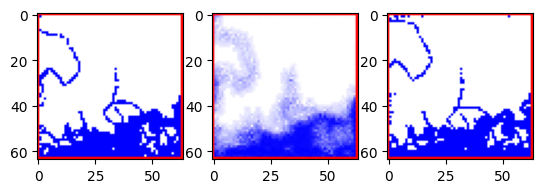

Epoch 2701, Loss: 3.235544204711914


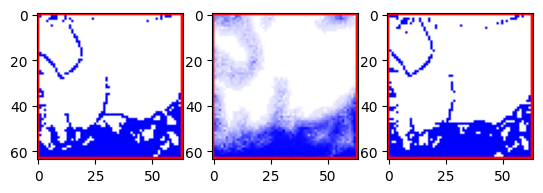

Epoch 2801, Loss: 3.1501145362854004


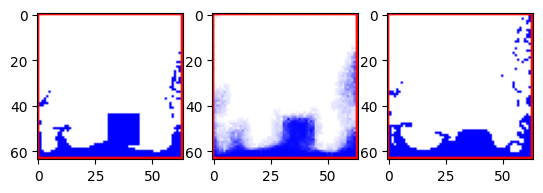

Epoch 2901, Loss: 2.759503126144409


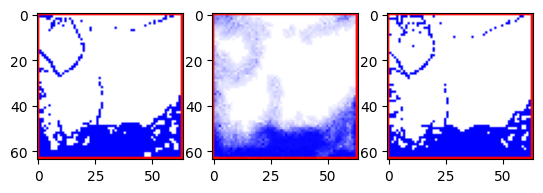

Epoch 3001, Loss: 1.0766737461090088


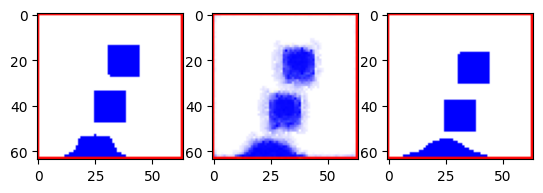

Epoch 3101, Loss: 6.740273475646973


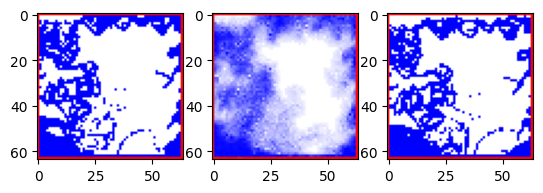

Epoch 3201, Loss: 3.135859251022339


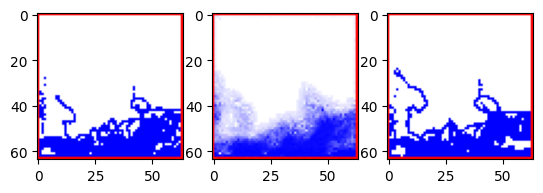

KeyboardInterrupt: 

In [243]:
train(10000)

In [244]:
model.save("testModel")

INFO:tensorflow:Assets written to: testModel/assets


INFO:tensorflow:Assets written to: testModel/assets


In [ ]:

def predict(init, iterations):
    x = init
    for i in range(iterations): 
        x= model(x, 1)
           

In [15]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>